In [1]:
import torch
import os


import torch
import lava.lib.dl.slayer as slayer
from lava.lib.dl import netx

import numpy as np

from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkSlayer
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils

import matplotlib.pyplot as plt

# get output from loaded lava net
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.s4d.ncmodels import NcModelSigmaS4dDelta
from lava.proc.s4d.process import SigmaS4dDelta
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
CompilerOptions.verbose = True
# Enable SLURM, the workload manager used to distribute Loihi2 resources to users
os.environ['SLURM'] = '1'
os.environ['PARTITION'] = "oheogulch"
os.environ['LOIHI_GEN'] = "N3B3"


random_seed = 18
import torch
torch.manual_seed(random_seed)
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
_, _, val_loader = utils.get_datasets() 
label, data_sample = next(enumerate(val_loader))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_rescaled = torch.transpose(data_sample[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2))


#int_bits = np.ceil(np.log2(diff_inp.max()- diff_inp.min())).int().item()
#inp_exp = 24 - 6 - int_bits - 1
inp_exp = 14

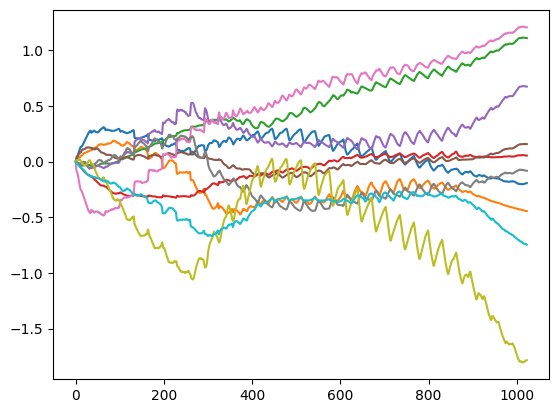

In [4]:
d_model=128
n_states=4
lava_dl_model_trained = SCIFARNetworkSlayer(d_model=d_model, n_states=n_states, num_layers=1, get_last=False)
lava_dl_model_trained.load_state_dict(torch.load("./../training_logs/Trained_slayer_quantized/network_quantized.pt"))
lava_dl_model_trained.eval();
out_dl_trained = lava_dl_model_trained(data_sample[0])
plt.plot(out_dl_trained[0].T.detach().numpy());

In [5]:
if os.path.exists("./../training_logs/netx_trained.net"):
    os.remove("./../training_logs/netx_trained.net")
lava_dl_model_trained.export_hdf5("./../training_logs/netx_trained.net")
num_message_bits = 24

loaded_net =  netx.hdf5.Network(net_config="./../training_logs/netx_trained.net", input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
print(loaded_net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  512|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|


In [6]:
def run_net(net, input_data):    
    n_steps = 1024 + len(loaded_net)
    spiker = SourceBuffer(data=input_datadata_rescaled = torch.transpose(data_sample[0], -1,-2)
diff_inp = data_rescaled[:,:, 1:] - data_rescaled[:, :, :-1]
diff_inp = torch.from_numpy(np.concatenate((data_rescaled[:, :, :1], diff_inp), axis=2)).reshape(3,1024) * 2**inp_exp)
    adapter_i = PyToNxAdapter(shape=(3,), num_message_bits=num_message_bits)
    adapter_o = NxToPyAdapter(shape=(10,), num_message_bits=num_message_bits)
    receiver = SinkBuffer(buffer = n_steps, shape=(10,))
    
    
    spiker.s_out.connect(adapter_i.inp)
    adapter_i.out.connect(net.inp)
    net.out.connect(adapter_o.inp)
    adapter_o.out.connect(receiver.a_in)
    
    adapter_i.run(condition=RunSteps(num_steps=n_steps), run_cfg=Loihi2HwCfg())    
    received_data_lava = receiver.data.get()
 
    out_lava = (received_data_lava.astype(np.int32) << 8) >> 8
    adapter_i.stop()
    return out_lava  / 2**inp_exp / 2**6
    

In [7]:
net =  netx.hdf5.Network(net_config='./../training_logs/netx_trained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
out_lava_trained = run_net(net, diff_inp)



Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


In [8]:
def plot(dl, lava, net):
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    axs[0].plot(dl[0][:, :30].detach().numpy().T);
    axs[1].plot(lava[:, len(net):30+len(net):].T, label=range(10));
    axs[2].plot(dl[0].detach().numpy().T);
    axs[3].plot(lava[:, len(net):].T, label=range(10))
    axs[4].plot(dl[0].T.detach() - lava[:, len(net):].T);
    plt.legend();


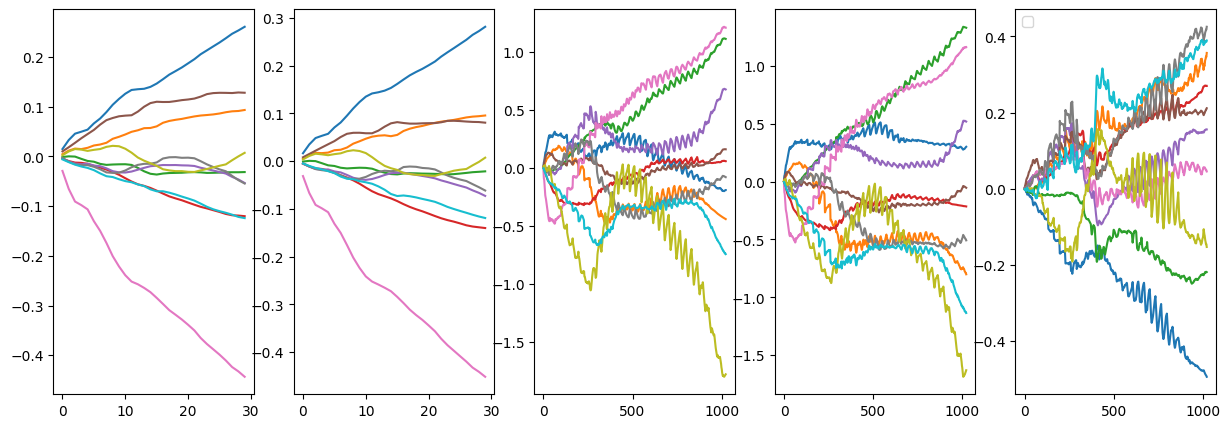

In [9]:
plot(out_dl_trained, out_lava_trained, loaded_net)

Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


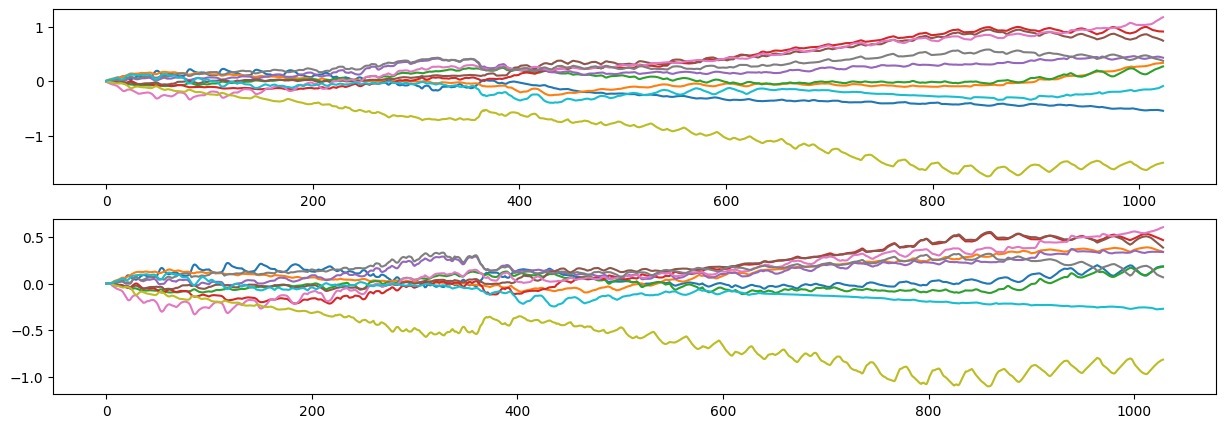

0 tensor([6]) 6 6
accuate pred_dl
accurate lava
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


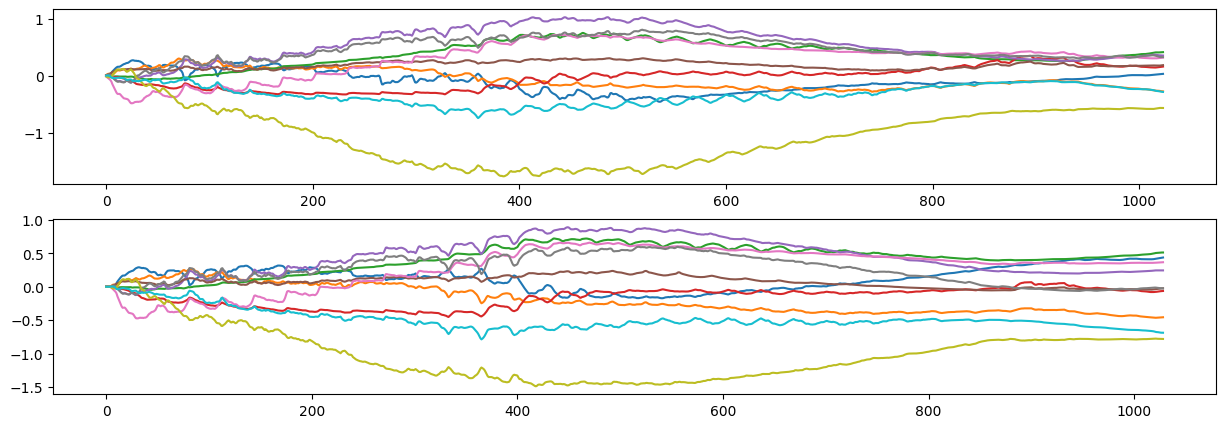

1 tensor([4]) 2 2
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


KeyboardInterrupt: 

In [10]:
preds = []
preds_dl = []
tgts = []
acc_lava = 0
acc_dl = 0

for batch_idx, [inp, tgt] in enumerate(val_loader):

    data_sample = torch.transpose(inp, -1,-2)
    diff_inp = data_sample[:,:, 1:] - data_sample[:, :, :-1]
    diff_inp = torch.from_numpy(np.concatenate((data_sample[:, :, :1], diff_inp), axis=2))
    
    net =  netx.hdf5.Network(net_config='./../training_logs/netx_trained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
    hw_out_full = run_net(net, diff_inp).T

    tgts.append(tgt.item())

    out_torch = lava_dl_model_trained(inp)
    pred_dl = out_torch[:, :, -1].argmax().item()
    if batch_idx < 5: 
        fig, axs = plt.subplots(2, 1, figsize=(15, 5))
        axs[0].plot(out_torch.detach().numpy().squeeze().T);        
        axs[1].plot(hw_out_full);
        plt.show()
    pred_lava = hw_out_full[-1,:].argmax().item()
    preds_dl.append(pred_dl)
    preds.append(pred_lava)

    print(batch_idx, tgt, pred_dl, pred_lava)
    if tgt == pred_dl:
        print("accuate pred_dl")
        acc_dl += 1
    if tgt == pred_lava:
        acc_lava += 1
        print("accurate lava")
    if batch_idx > 100:
        break

In [ ]:
print(tgts, preds_dl, preds)


In [ ]:
print(acc_dl, acc_lava)

In [ ]:
print(acc_dl, acc_lava)